# Importar librerías

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,classification_report
import pandas as pd
import csv
import os
from PIL import Image
import random

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions

## Función para reservar parte del fichero de muestras para test

In [2]:
def dividir_csv(fichero_entrada, fichero_salida1, fichero_salida2, porcentaje=70):
    """
    Divide un archivo CSV en dos archivos en función de un porcentaje.

    :param fichero_entrada: Ruta del archivo CSV de entrada.
    :param fichero_salida1: Ruta del primer archivo CSV de salida.
    :param fichero_salida2: Ruta del segundo archivo CSV de salida.
    :param porcentaje: Porcentaje de datos que debe ir al primer archivo (0-100).
    """
    # Asegurar que el porcentaje está entre 0 y 100
    if porcentaje < 0 or porcentaje > 100:
        raise ValueError("El porcentaje debe estar entre 0 y 100.")

    with open(fichero_entrada, mode='r', newline='') as f_entrada:
        lector_csv = list(csv.reader(f_entrada))
        
        # Obtener el encabezado y los datos
        encabezado = lector_csv[0]
        datos = lector_csv[1:]
        
        # Mezclar aleatoriamente las filas
        random.shuffle(datos)

        # Calcular el número de filas para cada archivo
        total_filas = len(datos)
        num_filas_salida1 = int(total_filas * porcentaje / 100)
        
        # Separar los datos
        datos_salida1 = datos[:num_filas_salida1]
        datos_salida2 = datos[num_filas_salida1:]

        # Escribir el primer archivo CSV
        with open(fichero_salida1, mode='w', newline='') as f_salida1:
            escritor_csv1 = csv.writer(f_salida1)
            escritor_csv1.writerow(encabezado)
            escritor_csv1.writerows(datos_salida1)

        # Escribir el segundo archivo CSV
        with open(fichero_salida2, mode='w', newline='') as f_salida2:
            escritor_csv2 = csv.writer(f_salida2)
            escritor_csv2.writerow(encabezado)
            escritor_csv2.writerows(datos_salida2)


## Data Loader

In [3]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Grayscale(),  # Convertir a blanco y negro
    transforms.Resize((96, 96)),  # Ajustar el tamaño si es necesario
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza a [-1, 1]
])

# Función para cargar las etiquetas desde un archivo CSV
def load_labels(csv_path,frac=1):
    df_1 = pd.read_csv(csv_path)
    df=df_1.sample(frac=frac)
    labels = {row['id']: row['label'] for _, row in df.iterrows()}
    return labels



# Dataset personalizado
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        '''
        # Filtrar solo las imágenes que existen
        self.img_ids = [img_id for img_id in labels.keys() if os.path.exists(os.path.join(img_dir, f'{img_id}.png'))]
        '''
        self.img_ids = list(labels.keys())  # Utilizamos todas las claves de etiquetas
        
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        
        # Cargar la imagen
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id]

        if self.transform:
            image = self.transform(image)

        return image, label

## Entrenamiento

Se implementa el entrenamiento mediante validación cruzada y con un callback para detener el entrenamiento con una paciencia de 5 épocas

In [4]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=30, batch_size=32, learning_rate=0.001, patience=5, l1_lambda=1e-5, l2_lambda=1e-4):
    # Device (CPU or GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Split the dataset into training and validation (80% training, 20% validation)
    total_size = len(train_loader.dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(train_loader.dataset, [train_size, val_size])

    # DataLoader for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # To store losses and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early Stopping variables
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Model training
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass and loss calculation
            outputs = model(images)
            loss = criterion(outputs, labels)

            '''
            # L1 regularization
            l1_reg = torch.tensor(0., requires_grad=True)
            for param in model.parameters():
                l1_reg = l1_reg + torch.norm(param, 1)
            loss = loss + l1_lambda * l1_reg

            # L2 regularization (in addition to weight decay in optimizer)
            l2_reg = torch.tensor(0., requires_grad=True)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param, 2)
            loss = loss + l2_lambda * l2_reg
            '''
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate loss and accuracy per epoch for the training set
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Model validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate loss
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate loss and accuracy per epoch for the validation set
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print results per epoch
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        # Early Stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Stopping training early at epoch {epoch+1} due to lack of improvement in validation accuracy.')
            break

    # Plot the evolution of loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

## Evaluación

In [5]:
# Función para evaluar el modelo
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Asegurarse de que el modelo está en el dispositivo correcto
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    
    return all_labels, all_preds



# Modelos

## Modelo basado en red neuronal preentrenada

In [6]:
# Modelo Preentrenado

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=2, num_neurons_fc=512):
        super(EfficientNetModel, self).__init__()
        
        # Cargar EfficientNet-B0 preentrenada
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        
        # Modificar la primera capa convolucional para aceptar 1 canal
        self.efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        
        # Congelar los parámetros de las capas preentrenadas
        for param in self.efficientnet.parameters():
            param.requires_grad = False
        
        # Obtener el número de características de entrada de la última capa totalmente conectada
        num_ftrs = self.efficientnet.classifier[1].in_features
        
        # Reemplazar la última capa completamente conectada
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_neurons_fc),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(num_neurons_fc, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)



# Implementación 

In [7]:
try:
    os.chdir('prueba_us')
except:
    pass

In [8]:
# Reservar el 10% de los datos para test
dividir_csv("train_labels.csv", "train.csv", "test.csv", porcentaje=90)

In [9]:
# Cargar los datasets
batch_size=128
# Cargar las etiquetas
train_labels = load_labels('train.csv')
train_dataset = CustomImageDataset(img_dir='train', labels=train_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

# Cargar etiquetas de prueba (si las necesitas para evaluación)
test_labels = load_labels('test.csv')
test_dataset = CustomImageDataset(img_dir='train', labels=test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

## Implementación modelo preentrenado

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Training Loss: 0.4697, Training Accuracy: 77.80%, Validation Loss: 0.4367, Validation Accuracy: 79.61%
Epoch 2/40, Training Loss: 0.4538, Training Accuracy: 78.80%, Validation Loss: 0.4291, Validation Accuracy: 80.32%
Epoch 3/40, Training Loss: 0.4477, Training Accuracy: 79.11%, Validation Loss: 0.4270, Validation Accuracy: 80.27%
Epoch 4/40, Training Loss: 0.4455, Training Accuracy: 79.27%, Validation Loss: 0.4320, Validation Accuracy: 79.95%
Epoch 5/40, Training Loss: 0.4424, Training Accuracy: 79.40%, Validation Loss: 0.4232, Validation Accuracy: 80.61%
Epoch 6/40, Training Loss: 0.4430, Training Accuracy: 79.41%, Validation Loss: 0.4247, Validation Accuracy: 80.49%
Epoch 7/40, Training Loss: 0.4406, Training Accuracy: 79.50%, Validation Loss: 0.4283, Validation Accuracy: 80.29%
Epoch 8/40, Training Loss: 0.4392, Training Accuracy: 79.69%, Validation Loss: 0.4229, Validation Accuracy: 80.49%
Epoch 9/40, Training Loss: 0.4391, Training Accuracy: 79.64%, Validation Loss: 0

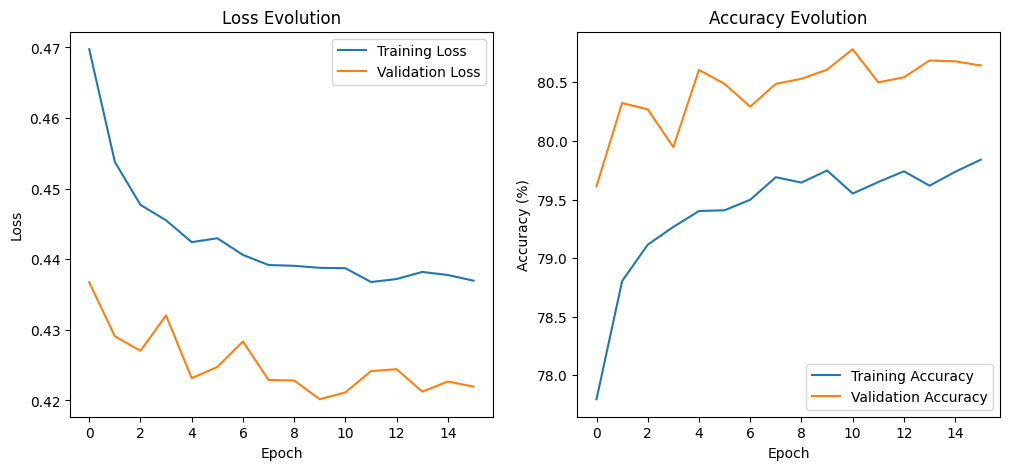

In [10]:
# Inicializar el modelo y moverlo al dispositivo
num_classes = len(set(train_labels.values()))
model_pretrain = EfficientNetModel(num_classes=num_classes)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrain.parameters(), lr=0.001,weight_decay=1e-4)

# Entrenamiento
train_model(model_pretrain, train_loader, num_epochs=40, batch_size=batch_size, learning_rate=0.001,criterion=criterion, optimizer=optimizer)

In [11]:
# Evaluar el modelo
labels, preds = evaluate_model(model_pretrain, test_loader)

# Mostrar el reporte de clasificación
print(classification_report(labels, preds, zero_division=0))

Precision: 0.8055, Recall: 0.8065, F1 Score: 0.8045
Confusion Matrix:
[[11465  1656]
 [ 2601  6281]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     13121
           1       0.79      0.71      0.75      8882

    accuracy                           0.81     22003
   macro avg       0.80      0.79      0.80     22003
weighted avg       0.81      0.81      0.80     22003



In [12]:
# Salvar el modelo
torch.save(model_pretrain.state_dict(), 'pretrain.pth')